# Differential Vision on AgentNet Trajectories

Explore how differential vision works across curated screen trajectories (agentnet_curated).

This notebook:
- Computes patch-level changes between consecutive frames
- Visualizes changed regions (overlays, heatmaps)
- Summarizes per-frame and per-trajectory change ratios
- Estimates latency savings from caching vs full encode
- (Optional) Hooks into the full model pipeline to measure real timing


In [10]:
# Add repo root to path for imports
import sys
from pathlib import Path
repo_root = Path().resolve().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
print(f"Added to path: {repo_root}")

Added to path: /home/sdan/storage/diffcua


In [11]:
# Imports
import os, re, json, math, time, itertools, textwrap
from pathlib import Path

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Optional deps
try:
    import pandas as pd
except Exception:
    pd = None
try:
    import seaborn as sns
    sns.set_context('talk')
except Exception:
    sns = None

# Local diffs utilities
from differential_vision.patch_utils import compute_patch_diff, visualize_changed_patches


In [12]:
# Config
DATA_ROOT = Path('../differential_vision/agentnet_curated')  # directory containing traj_*/
PATCH_SIZE = 24         # should match the vision tower's patch size
DIFF_THRESHOLD = 0.05   # sensitivity to change (0..1)
MAX_CHANGED_PATCHES = 50  # classify as partial vs full
SAMPLE_TRAJ = 8         # how many trajectories to sample (None for all)
MAX_FRAMES_PER_TRAJ = 120  # limit frames per trajectory for speed (None for all)

# Heatmap aggregation target grid (resizes per-frame patch masks)
HEATMAP_H, HEATMAP_W = 64, 64

# Latency modeling (rough estimates if not running the full model)
T_FULL_MS = 220.0       # baseline full-encode time (first frame), adjust to your hardware
T_CACHE_MS = 2.0        # cache hit overhead
PARTIAL_OVERHEAD_MS = 4.0  # setup overhead per partial update

# Optional: enable real model timing via predict.py from this repo
ENABLE_MODEL_TIMING = False
MODEL_PATH = os.environ.get('FASTVLM_MODEL_PATH', './llava-v1.5-13b')


In [13]:
# Helpers
def _natural_sort_key(path: Path):
    name = path.name
    return [int(tok) if tok.isdigit() else tok.lower() for tok in re.split(r'(\d+)', name)]

def list_trajectories(root: Path):
    trajs = sorted([p for p in root.iterdir() if p.is_dir() and p.name.startswith('traj_')], key=_natural_sort_key)
    return trajs

def list_frames(traj_dir: Path):
    imgs = sorted([p for p in traj_dir.iterdir() if p.suffix.lower() in {'.png', '.jpg', '.jpeg'}], key=_natural_sort_key)
    return imgs

def load_image(path: Path):
    img = Image.open(path).convert('RGB')
    return np.array(img)

def classify_encoding(changed_count: int, total_patches: int):
    if changed_count == 0:
        return 'cache'
    if changed_count <= MAX_CHANGED_PATCHES:
        return 'partial'
    return 'full'

def estimate_latency_ms(changed_count: int, total_patches: int):
    # Simple model: proportional to changed fraction + small overhead
    if changed_count == 0:
        return T_CACHE_MS
    frac = changed_count / max(1, total_patches)
    return PARTIAL_OVERHEAD_MS + frac * T_FULL_MS

def resize_mask(mask: np.ndarray, out_h: int, out_w: int) -> np.ndarray:
    # mask: HxW boolean or float; resize with PIL for simplicity
    m = mask.astype(np.float32)
    m_img = Image.fromarray((m * 255).astype(np.uint8))
    m_resized = m_img.resize((out_w, out_h), resample=Image.BILINEAR)
    return (np.array(m_resized).astype(np.float32) / 255.0)

def summarize_records(records):
    # records: list of dicts
    total = len(records)
    by_enc = {}
    ratios = []
    for r in records:
        by_enc[r['encoding']] = by_enc.get(r['encoding'], 0) + 1
        ratios.append(r['changed_ratio'])
    return total, by_enc, np.array(ratios, dtype=float)


In [14]:
# Scan trajectories and compute per-frame change masks
traj_dirs = list_trajectories(DATA_ROOT)
if SAMPLE_TRAJ is not None:
    traj_dirs = traj_dirs[:SAMPLE_TRAJ]

all_records = []
heatmap_acc = np.zeros((HEATMAP_H, HEATMAP_W), dtype=np.float32)
per_traj_stats = {}

for ti, traj in enumerate(traj_dirs, start=1):
    frames = list_frames(traj)
    if MAX_FRAMES_PER_TRAJ is not None:
        frames = frames[:MAX_FRAMES_PER_TRAJ]
    if len(frames) < 2:
        continue
    print(f'Traj {ti}/{len(traj_dirs)}: {traj.name} (frames={len(frames)})')

    # Incremental diff between consecutive frames
    prev = load_image(frames[0])
    total_time_ms = 0.0
    baseline_total_ms = T_FULL_MS * len(frames)
    for fi, f in enumerate(frames, start=0):
        cur = load_image(f) if fi > 0 else prev
        # Compute patch mask (prev vs cur)
        changed = compute_patch_diff(prev, cur, patch_size=PATCH_SIZE, threshold=DIFF_THRESHOLD)
        grid_h, grid_w = changed.shape
        changed_count = int(changed.sum())
        total_patches = int(changed.size)
        ratio = changed_count / max(1, total_patches)
        enc_type = classify_encoding(changed_count, total_patches)

        # Accumulate heatmap
        heatmap_acc += resize_mask(changed.astype(np.float32), HEATMAP_H, HEATMAP_W)

        # Estimate latency for this frame
        frame_ms = T_FULL_MS if fi == 0 else estimate_latency_ms(changed_count, total_patches)
        total_time_ms += frame_ms

        all_records.append({
            'traj': traj.name,
            'frame_idx': fi,
            'path': str(f),
            'grid_h': grid_h, 'grid_w': grid_w,
            'changed_count': changed_count, 'total_patches': total_patches,
            'changed_ratio': ratio, 'encoding': enc_type,
            'est_time_ms': frame_ms,
        })

        prev = cur
    speedup = baseline_total_ms / max(1e-6, total_time_ms)
    per_traj_stats[traj.name] = {
        'frames': len(frames),
        'baseline_ms': baseline_total_ms,
        'actual_ms': total_time_ms,
        'speedup_vs_baseline': speedup,
    }

print('Done.')


Traj 1/8: traj_0000 (frames=89)
Traj 2/8: traj_0001 (frames=59)
Traj 3/8: traj_0002 (frames=58)
Traj 4/8: traj_0003 (frames=57)
Traj 5/8: traj_0004 (frames=54)
Traj 6/8: traj_0005 (frames=52)
Traj 7/8: traj_0006 (frames=51)
Traj 8/8: traj_0007 (frames=50)
Done.


Total frames analyzed: 470
Encoding breakdown: {'cache': 14, 'full': 348, 'partial': 108}
Avg changed ratio: 0.262  (median=0.133)


,traj,frame_idx,path,grid_h,grid_w,changed_count,total_patches,changed_ratio,encoding,est_time_ms
0,traj_0000,0,../differential_vision/agentnet_curated/traj_0...,32,51,0,1632,0.000000,cache,220.000000
1,traj_0000,1,../differential_vision/agentnet_curated/traj_0...,32,51,104,1632,0.063725,full,18.019608
2,traj_0000,2,../differential_vision/agentnet_curated/traj_0...,32,51,1486,1632,0.910539,full,204.318627


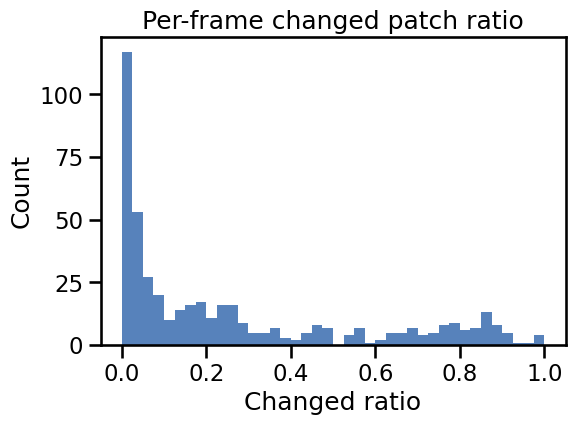

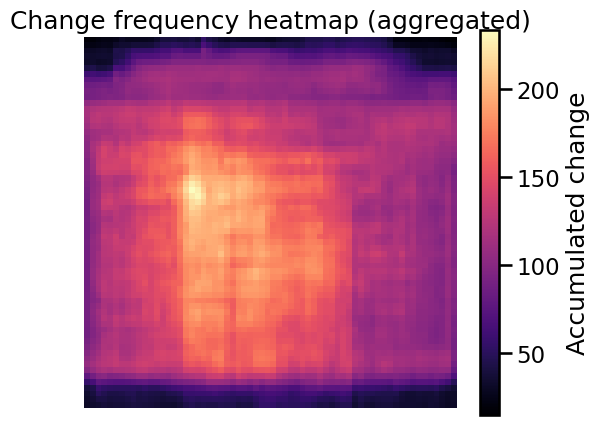

In [15]:
# Overview stats
total, by_enc, ratios = summarize_records(all_records)
print(f'Total frames analyzed: {total}')
print('Encoding breakdown:', by_enc)
print(f'Avg changed ratio: {ratios.mean():.3f}  (median={np.median(ratios):.3f})')

if pd is not None:
    df = pd.DataFrame(all_records)
    display(df.head(3))
else:
    df = None

# Plot histogram of changed ratios
plt.figure(figsize=(6,4))
plt.hist(ratios, bins=40, color='#4575b4', alpha=0.9)
plt.title('Per-frame changed patch ratio')
plt.xlabel('Changed ratio')
plt.ylabel('Count')
plt.show()

# Plot aggregate heatmap (frequency of changes across screen regions)
plt.figure(figsize=(6,5))
plt.imshow(heatmap_acc, cmap='magma')
plt.title('Change frequency heatmap (aggregated)')
plt.colorbar(label='Accumulated change')
plt.axis('off')
plt.show()


Selected trajectory: traj_0005


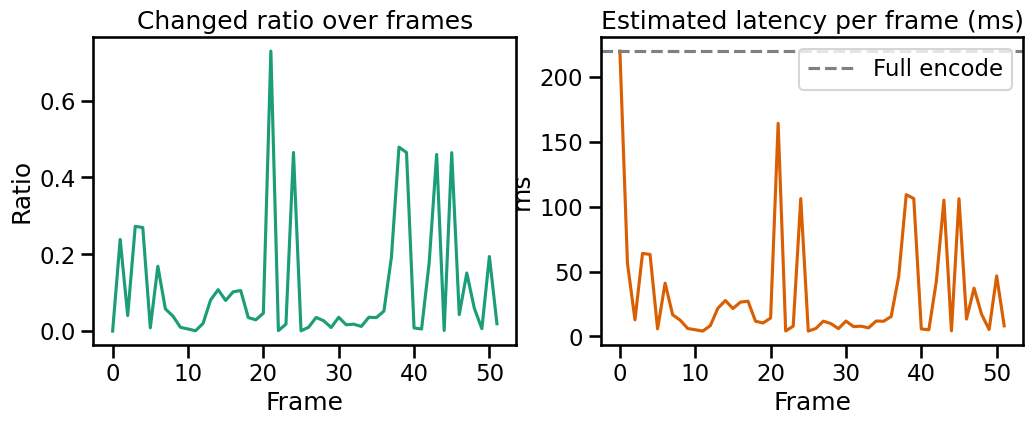

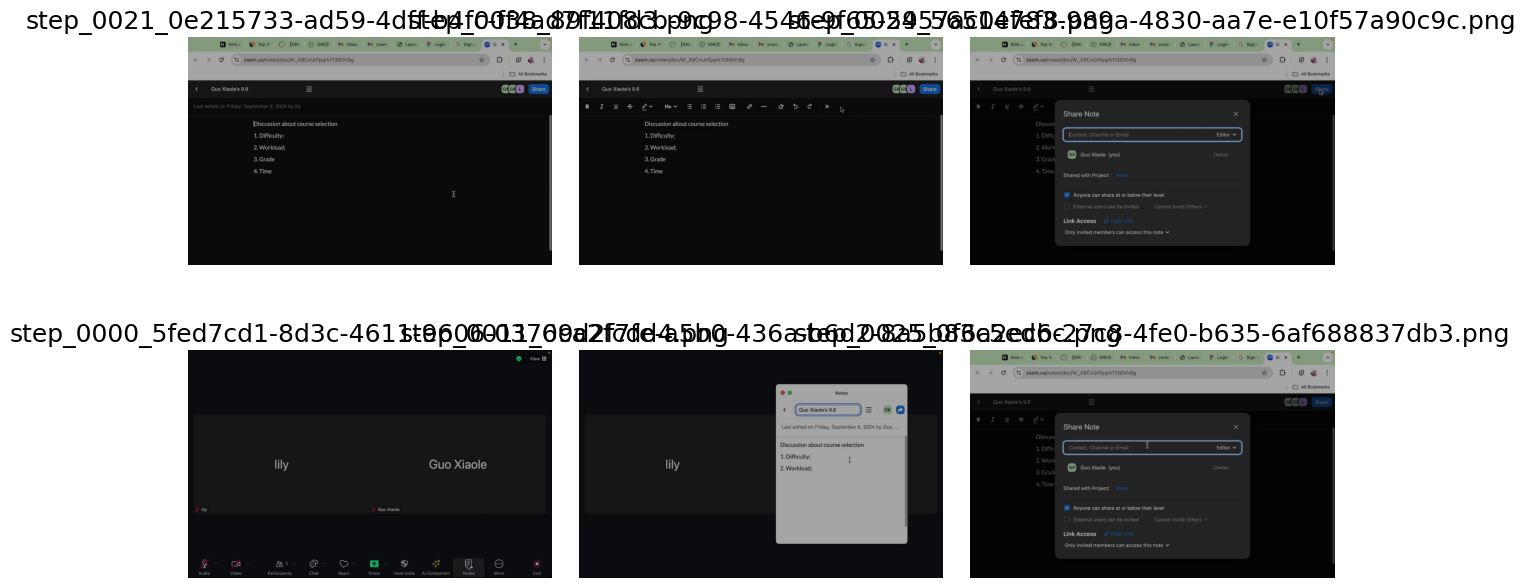

In [16]:
# Visualize a single trajectory: overlay changed patches and time series
if pd is not None and df is not None:
    # Pick the trajectory with the biggest estimated speedup
    best_traj = max(per_traj_stats.items(), key=lambda kv: kv[1]['speedup_vs_baseline'])[0]
    sub = df[df.traj == best_traj].copy()
else:
    # Fallback: pick the most recent
    best_traj = traj_dirs[-1].name if traj_dirs else None
    sub = [r for r in all_records if r['traj'] == best_traj]

print('Selected trajectory:', best_traj)

# Plot time series of changed ratio and estimated latency
if pd is not None and isinstance(sub, pd.DataFrame):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    ax[0].plot(sub['frame_idx'], sub['changed_ratio'], color='#1b9e77')
    ax[0].set_title('Changed ratio over frames')
    ax[0].set_xlabel('Frame')
    ax[0].set_ylabel('Ratio')

    ax[1].plot(sub['frame_idx'], sub['est_time_ms'], color='#d95f02')
    ax[1].axhline(T_FULL_MS, color='gray', linestyle='--', label='Full encode')
    ax[1].set_title('Estimated latency per frame (ms)')
    ax[1].set_xlabel('Frame')
    ax[1].set_ylabel('ms')
    ax[1].legend()
    plt.show()
else:
    xs = [r['frame_idx'] for r in sub]
    ys = [r['changed_ratio'] for r in sub]
    ys2 = [r['est_time_ms'] for r in sub]
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    ax[0].plot(xs, ys, color='#1b9e77')
    ax[0].set_title('Changed ratio over frames')
    ax[0].set_xlabel('Frame'); ax[0].set_ylabel('Ratio')
    ax[1].plot(xs, ys2, color='#d95f02')
    ax[1].axhline(T_FULL_MS, color='gray', linestyle='--', label='Full encode')
    ax[1].set_title('Estimated latency per frame (ms)')
    ax[1].set_xlabel('Frame'); ax[1].set_ylabel('ms'); ax[1].legend()
    plt.show()

# Show overlays for 6 representative frames
if pd is not None and isinstance(sub, pd.DataFrame):
    sample = pd.concat([
        sub.sort_values('changed_ratio', ascending=False).head(3),
        sub.sort_values('changed_ratio', ascending=True).head(3)
    ])
    sample_paths = sample['path'].tolist()
else:
    sample_sorted = sorted(sub, key=lambda r: r['changed_ratio'], reverse=True)
    sample_paths = [r['path'] for r in sample_sorted[:3]] + [r['path'] for r in sample_sorted[-3:]]

n = len(sample_paths)
cols = 3
rows = math.ceil(n / cols)
plt.figure(figsize=(4*cols, 3.5*rows))
for i, p in enumerate(sample_paths, start=1):
    img = np.array(Image.open(p).convert('RGB'))
    # Compute changed mask vs previous frame
    # (best-effort: find previous frame path by replacing index if available)
    m = re.search(r'(\d+)', Path(p).name)
    if m:
        idx = int(m.group(1))
        prev_name = re.sub(r'(\d+)', f'{max(0, idx-1):04d}', Path(p).name, count=1)
        prev_path = Path(p).with_name(prev_name)
        prev_img = np.array(Image.open(prev_path).convert('RGB')) if prev_path.exists() else img
    else:
        prev_img = img
    changed = compute_patch_diff(prev_img, img, patch_size=PATCH_SIZE, threshold=DIFF_THRESHOLD)
    vis = visualize_changed_patches(img, changed, patch_size=PATCH_SIZE, alpha=0.35)
    plt.subplot(rows, cols, i)
    plt.imshow(vis)
    plt.title(Path(p).name)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Optional: Real timing via the full model

If GPU + model weights are available, you can measure real per-frame timings using the repo's `predict.py`.
This will run the model with differential encoding enabled and print summaries per sequence.

Notes:
- Ensure model weights are available at `MODEL_PATH`
- Use `--force-pad-aspect` to avoid anyres batching and enable partial updates
- Use `--benchmark` for timing breakdowns and `--diff-print-stats` for encoder stats


In [17]:
if ENABLE_MODEL_TIMING:
    # This cell runs the CLI, which prints per-sequence summaries.
    # You can redirect to a log file and parse, if desired.
    seq_limit = SAMPLE_TRAJ if SAMPLE_TRAJ is not None else 5
    cmd = (
        f"python predict.py --model-path {MODEL_PATH} \
           --sequence-root {DATA_ROOT} --sequence-limit {seq_limit} \
           --prompt 'Describe the screen.' --benchmark \
           --diff-print-stats --force-pad-aspect"
    )
    print('Running:', cmd)
    !$cmd
else:
    print('Set ENABLE_MODEL_TIMING=True to run real model timing (requires weights + GPU).')


Set ENABLE_MODEL_TIMING=True to run real model timing (requires weights + GPU).


## Visualize Specific Patches and Heatmap

This section lets you (a) pick specific patch coordinates to track across frames, and (b) overlay a per-patch change heatmap to see what changes within each photo.


Auto-selected patches from frame 21 : [(14, 46), (14, 47), (14, 48), (32, 41)]


/tmp/ipykernel_2879783/3649730088.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap(cmap)(norm)[..., :3]  # [gh, gw, 3] in [0,1]


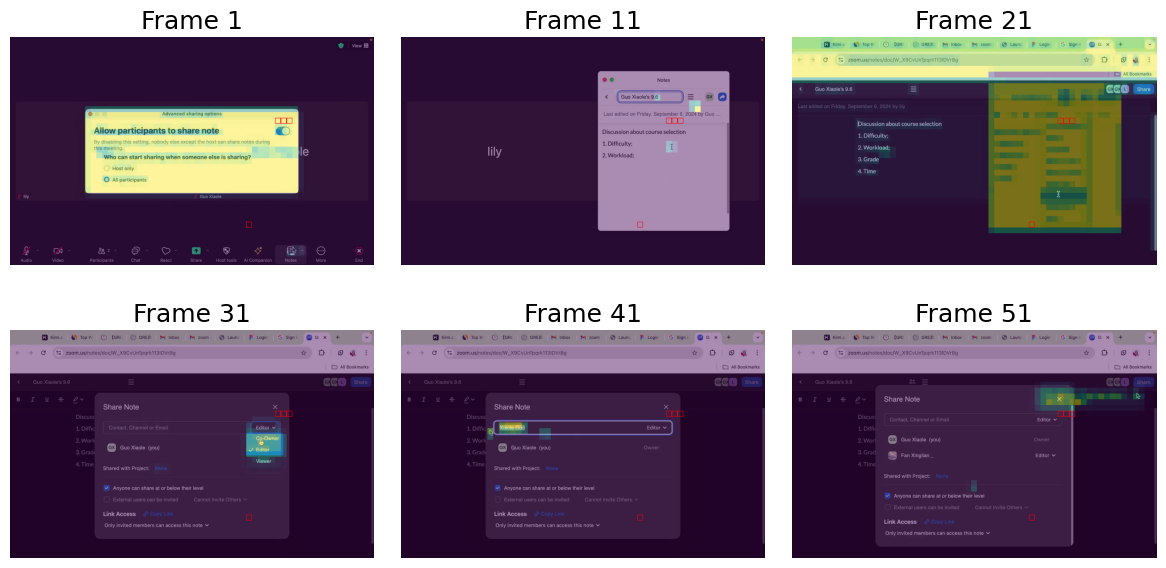

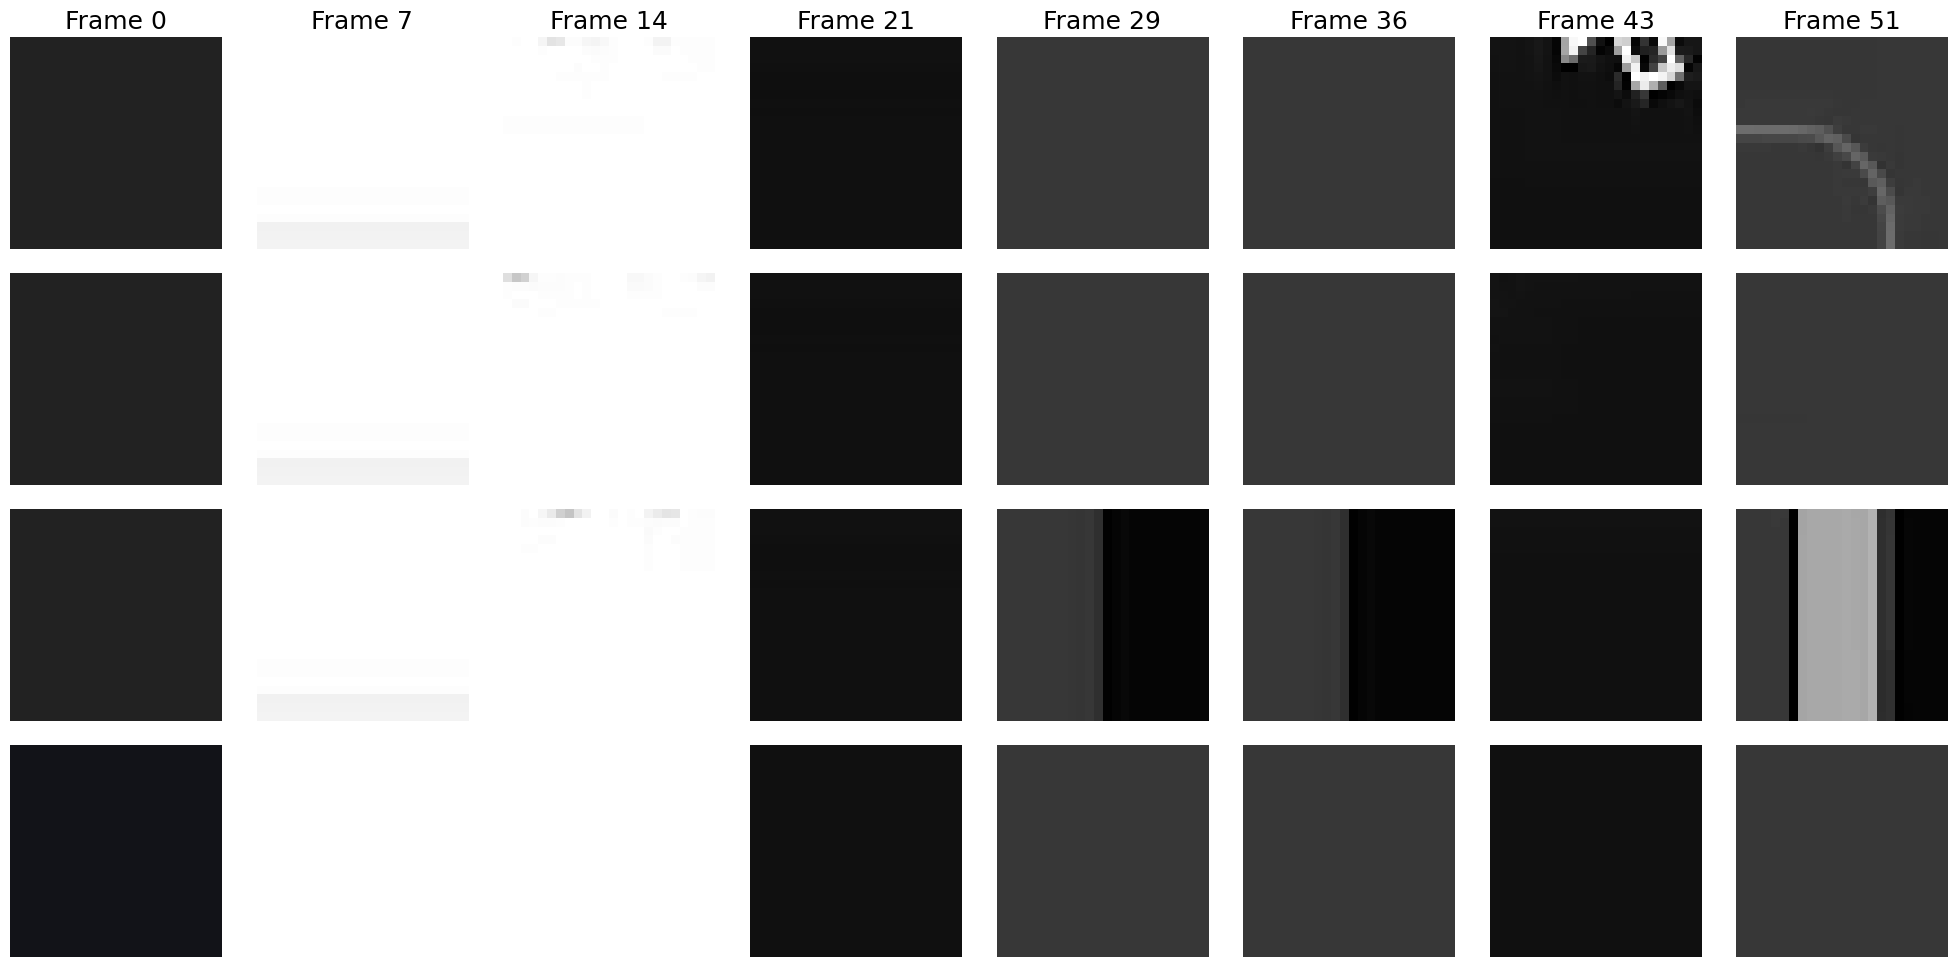

Done.


In [18]:
import numpy as np, math, re
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from differential_vision.patch_utils import compute_patch_diff_values, overlay_patch_rects, extract_patch

# Parameters
PATCH = PATCH_SIZE if 'PATCH_SIZE' in globals() else 24
AUTO_TOPK = 4              # set >0 to auto-pick top-K changed patches from a chosen frame
TOPK_FRAME_IDX = None      # e.g., 25; None picks the frame with max change
SELECTED_PATCHES = []      # list of (row, col); if empty and AUTO_TOPK>0, it auto-selects
HEATMAP_SAMPLE = 6         # number of frames to visualize heatmap overlays
TRAJ = best_traj if 'best_traj' in globals() else (traj_dirs[-1].name if 'traj_dirs' in globals() and len(traj_dirs) else None)

assert TRAJ is not None, 'No trajectory selected. Run earlier cells to define best_traj or set TRAJ manually.'

# Gather frame paths for the selected trajectory
if 'pd' in globals() and 'df' in globals() and df is not None:
    sub_df = df[df.traj == TRAJ].sort_values('frame_idx').reset_index(drop=True)
    frame_paths = sub_df['path'].tolist()
else:
    # Fallback: scan directory
    traj_dir = Path(DATA_ROOT) / TRAJ if 'DATA_ROOT' in globals() else None
    assert traj_dir and traj_dir.exists(), f'Trajectory directory not found: {traj_dir}'
    frame_paths = sorted([str(p) for p in traj_dir.glob('*.png')] + [str(p) for p in traj_dir.glob('*.jpg')])
    # Sort numerically if possible
    def _k(p):
        m = re.search(r'(\d+)', Path(p).name); return int(m.group(1)) if m else p
    frame_paths = sorted(frame_paths, key=_k)

def _load_img(p):
    return np.array(Image.open(p).convert('RGB'))

def heatmap_overlay(img, diff_map, patch_size, alpha=0.45, cmap='viridis'):
    import matplotlib.cm as cm
    base = (img if img.max() > 1 else img*255).astype(np.uint8)
    H, W = base.shape[:2]
    gh, gw = diff_map.shape
    if diff_map.max() <= 1e-6:
        norm = diff_map
    else:
        norm = (diff_map - diff_map.min()) / (np.ptp(diff_map) + 1e-6)
    colors = cm.get_cmap(cmap)(norm)[..., :3]  # [gh, gw, 3] in [0,1]
    heat = np.zeros_like(base, dtype=np.float32)
    for i in range(gh):
        for j in range(gw):
            y0, x0 = i*patch_size, j*patch_size
            y1, x1 = min(y0+patch_size, H), min(x0+patch_size, W)
            heat[y0:y1, x0:x1] = colors[i, j] * 255.0
    out = base.astype(np.float32)*(1-alpha) + heat*alpha
    return out.astype(np.uint8)

# Compute per-frame diff maps vs previous frame
imgs = [_load_img(p) for p in frame_paths]
diff_maps = []
for t in range(len(imgs)):
    if t == 0:
        diff_maps.append(None)
    else:
        diff_maps.append(compute_patch_diff_values(imgs[t-1], imgs[t], patch_size=PATCH))

# Auto-select top-K patches from a chosen frame if none provided
if not SELECTED_PATCHES and AUTO_TOPK > 0 and len(imgs) > 1:
    if TOPK_FRAME_IDX is None:
        # pick the frame with maximum total change
        totals = [0] + [m.sum() if m is not None else 0 for m in diff_maps[1:]]
        t_sel = int(np.argmax(totals))
    else:
        t_sel = int(TOPK_FRAME_IDX)
        t_sel = min(max(t_sel, 1), len(imgs)-1)
    dm = diff_maps[t_sel]
    flat_idx = np.argsort(dm.reshape(-1))[-AUTO_TOPK:]
    gh, gw = dm.shape
    SELECTED_PATCHES = [(int(i//gw), int(i%gw)) for i in flat_idx.tolist()][::-1]
    print('Auto-selected patches from frame', t_sel, ':', SELECTED_PATCHES)

# Heatmap overlays for representative frames
if len(imgs) > 1:
    sample_t = np.unique(np.clip(np.linspace(1, len(imgs)-1, HEATMAP_SAMPLE, dtype=int), 1, len(imgs)-1))
    cols = min(3, len(sample_t))
    rows = int(np.ceil(len(sample_t)/cols))
    plt.figure(figsize=(4*cols, 3.2*rows))
    for k, t in enumerate(sample_t, start=1):
        overlay = heatmap_overlay(imgs[t], diff_maps[t], PATCH, alpha=0.45)
        if SELECTED_PATCHES:
            overlay = overlay_patch_rects(overlay, SELECTED_PATCHES, patch_size=PATCH, color=(255, 0, 0), thickness=2)
        plt.subplot(rows, cols, k)
        plt.imshow(overlay)
        plt.title(f'Frame {t}')
        plt.axis('off')
    plt.tight_layout(); plt.show()

# Patch crops across time (trajectory view)
if SELECTED_PATCHES:
    sample_t = np.unique(np.clip(np.linspace(0, len(imgs)-1, min(8, len(imgs)), dtype=int), 0, len(imgs)-1))
    rows = len(SELECTED_PATCHES)
    cols = len(sample_t)
    plt.figure(figsize=(2.5*cols, 2.5*rows))
    for r, (pi, pj) in enumerate(SELECTED_PATCHES):
        for c, t in enumerate(sample_t):
            patch = extract_patch(imgs[t], pi, pj, patch_size=PATCH)
            ax = plt.subplot(rows, cols, r*cols + c + 1)
            ax.imshow(patch)
            if c == 0:
                ax.set_ylabel(f'Patch ({pi},{pj})')
            if r == 0:
                ax.set_title(f'Frame {t}')
            ax.axis('off')
    plt.tight_layout(); plt.show()

print('Done.')


## What to look for

- Many frames have near-zero changed ratio → cache hits, near-instant
- Small interactions (clicks, cursor moves) → very low ratios → partial updates
- Large transitions (scrolls, page changes) → high ratios → full encodes
- Aggregated heatmap should highlight UI hotspots (cursor area, buttons, text inputs)
- Estimated per-trajectory speedup vs "always full-encode" baseline
